In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as T
from torchvision.transforms import ToTensor, Lambda, Compose, Resize, ToTensor

import matplotlib.pyplot as plt

from PIL import Image

import requests
import numpy as np

from collections import defaultdict
from abc import abstractmethod

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
set_deterministic = True

def reset_seeds(seed=42):
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

if set_deterministic:
  import os
  import random
  os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
  reset_seeds()
  torch.use_deterministic_algorithms(True)
  torch.backends.cudnn.deterministic = True

# DATA

## Test Images

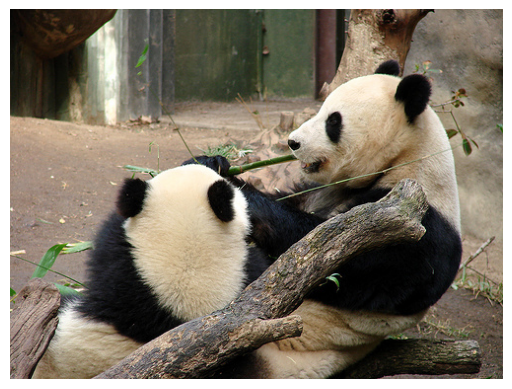

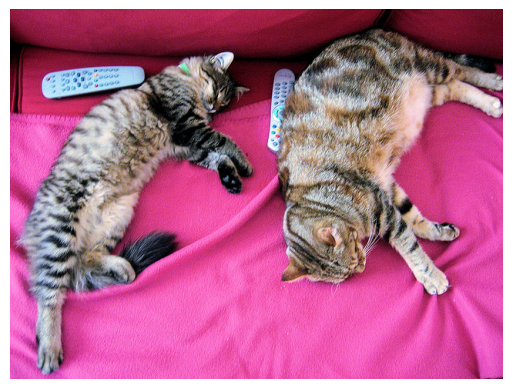

In [ ]:
image_panda = Image.open(requests.get("https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02510455_giant_panda.JPEG", stream=True).raw)
plt.imshow(image_panda)
plt.axis('off')
plt.show()

image_cat = Image.open(requests.get("http://images.cocodataset.org/val2017/000000039769.jpg", stream=True).raw)
plt.imshow(image_cat)
plt.axis('off')
plt.show()

test_imgs = [image_panda, image_cat]
gt_labels = ['a panda','a cat']

## Tiny-ImageNet

In [ ]:
!pip install -U datasets

In [ ]:
# load dataset
from datasets import load_dataset, load_dataset, get_dataset_split_names, get_dataset_infos

tiny_ds_name = 'zh-plus/tiny-imagenet'
get_dataset_split_names(tiny_ds_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


['train', 'valid']

In [ ]:
ds_info = get_dataset_infos(tiny_ds_name)
tiny_ds_wnids = ds_info['default'].features['label'].names

tiny_ds_wnids[:5]

['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640']

In [ ]:
# load dataset labels
import json

imagenet_class_index = requests.get("https://raw.githubusercontent.com/raghakot/keras-vis/refs/heads/master/resources/imagenet_class_index.json", stream=True).json()
imagenet_class_index = {int(k):v for k,v in imagenet_class_index.items()}

rand_id = np.random.randint(low=0,high=len(imagenet_class_index))
print(f'Random class: \t [{rand_id}] {imagenet_class_index[rand_id][1]}')

Random class: 	 [102] echidna


In [ ]:
# class id mappings:

# WNID -> index
wnid_to_index = {v[0]: int(k) for k, v in imagenet_class_index.items()}

# index -> WNID
index_to_wnid = {int(k): v[0]  for k, v in imagenet_class_index.items()}

# num_label -> str_label
index_to_label = {int(k): ' '.join(v[1].split('_')) for k, v in imagenet_class_index.items()}

In [ ]:
# hardcoding labels for incorrect ones (see https://huggingface.co/datasets/zh-plus/tiny-imagenet/discussions/1)
hardcoded_labels = {}
hardcoded_labels['n02666347'] = 'n02666196'
hardcoded_labels['n03373237'] = 'n02190166'
hardcoded_labels['n04465666'] = 'n04465501'
hardcoded_labels['n04598010'] = 'n04597913'
hardcoded_labels['n07056680'] = 'n04067472'
hardcoded_labels['n07646821'] = 'n01855672'
hardcoded_labels['n07647870'] = 'n03250847'
hardcoded_labels['n07657664'] = 'n07579787'
hardcoded_labels['n07975909'] = 'n02206856'
hardcoded_labels['n08496334'] = 'n02730930'
hardcoded_labels['n08620881'] = 'n03976657'
hardcoded_labels['n08742578'] = 'n02085620'
hardcoded_labels['n12520864'] = 'n02906734'
hardcoded_labels['n13001041'] = 'n07734744'
hardcoded_labels['n13652335'] = 'n03804744'
hardcoded_labels['n13652994'] = 'n02999410'
hardcoded_labels['n13719102'] = 'n01945685'
hardcoded_labels['n14991210'] = 'n07747607'

In [ ]:
tiny_label_to_text = {}
for i, wnid in enumerate(tiny_ds_wnids):
  if wnid not in wnid_to_index.keys():
    wnid = hardcoded_labels[wnid]

  id = wnid_to_index[wnid]
  tiny_label_to_text[i] = index_to_label[id]

# tiny_label_to_text

In [ ]:
# MISALIGNMENT BETWEEN   a) TinyImageNet numerical labels and    b) ImageNet ones:
#   mapping from (a) to (b) via the class wnid

tinyImgN_label_to_ImgN_label = {}

for num_id, wn_id in enumerate(tiny_ds_wnids):
  if wn_id not in wnid_to_index.keys():
    wn_id = hardcoded_labels[wn_id]
  tinyImgN_label_to_ImgN_label[num_id] = wnid_to_index[wn_id]

# and opposite mapping: model prediction labels (ImageNet ones) to TinyImageNet numerical
imgN_label_to_tinyImgN_label = {v: k for k, v in tinyImgN_label_to_ImgN_label.items()}

In [ ]:
ds_preprocess = Compose([
    Resize((224, 224)),
    ToTensor(),
    ])

tiny_ds = load_dataset(tiny_ds_name, split='valid').with_format(type='torch', columns=['image', 'label'])

def transforms(examples):
    examples["image"] = [ds_preprocess(img.convert("RGB")) for img in examples["image"]]
    return examples
tiny_ds = tiny_ds.with_transform(transforms)

batch_size=32
dataloader = DataLoader(tiny_ds, batch_size=batch_size, shuffle=True, num_workers=2)

SHAPEs: torch.Size([32, 3, 224, 224]) torch.Size([32]) 



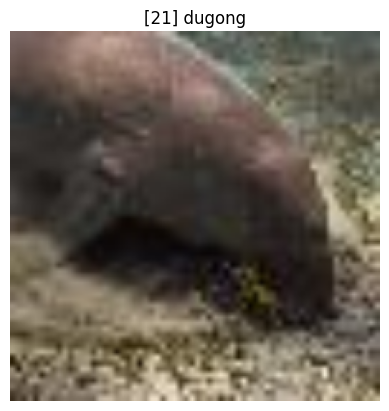

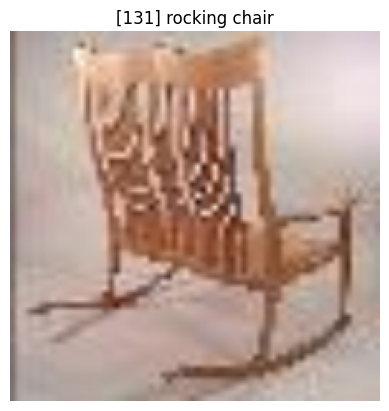

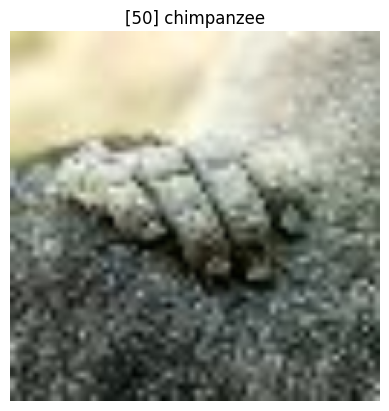

In [ ]:
# show 3 random imgs
for batch in dataloader:
  imgs = batch['image']
  labels = batch['label']
  print('SHAPEs:', imgs.shape, labels.shape, '\n')
  for i in range(3):
    plt.imshow(imgs[i].permute(1, 2, 0))
    plt.axis('off')
    # plt.title(f'[{labels[i]}] {_tiny_label_to_text[tinyImgN_label_to_ImgN_label[labels[i].item()]]}')
    plt.title(f'[{labels[i]}] {tiny_label_to_text[labels[i].item()]}')
    plt.show()
  break

In [ ]:
# generate captions from all dataset classes

all_captions = []
for label in tiny_label_to_text.values():
  all_captions.append(f'a picture of a {label}')

start_id = np.random.randint(low=0,high=len(all_captions)-5)
all_captions[start_id:start_id+5]

['a picture of a pomegranate',
 'a picture of a meat loaf',
 'a picture of a pizza',
 'a picture of a potpie',
 'a picture of a espresso']

# MODELS

In [ ]:
run_simple_model_tests = False

## CLIP
 - ResNet50
 - ViT-B/16

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

import clip

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-_zmd9nux
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-_zmd9nux
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
if run_simple_model_tests:
  av_models = clip.available_models()
  tested_model_names = []
  for model_name in ['RN50', 'RN101', 'ViT-B/16', 'ViT-L/14']:
  # for model_name in ['RN50']:
    if model_name in av_models:
      tested_model_names.append(model_name)

  print(f'TESTING CLIP MODELS: {tested_model_names}')

In [ ]:
if run_simple_model_tests:
  for model_name in tested_model_names:
    print(f'Model: {model_name}')
    model, preprocess = clip.load(model_name, device=device)

    for test_img, gt_label in zip(test_imgs, gt_labels):
      image = preprocess(test_img).unsqueeze(0).to(device)
      labels = ["a diagram", "a dog", "a cat", 'a panda']
      text = clip.tokenize(labels).to(device)

      with torch.no_grad():
          logits_per_image, logits_per_text = model(image, text)
          probs = logits_per_image.softmax(dim=-1).cpu().numpy()

      print(f'GT: {gt_label}')
      print(f"PRED: {labels[np.argmax(probs)]} [{np.max(probs)}], probs: {['{:.3f}'.format(prob) for prob in probs[0]]}")
    print('\n')

## Perception Encoder

https://colab.research.google.com/github/facebookresearch/perception_models/blob/main/apps/pe/docs/pe_demo.ipynb#scrollTo=38f80aa1

In [ ]:
import os, sys
import torch
import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !git clone https://github.com/facebookresearch/perception_models.git
    !pip install decord
    !pip install ftfy
    sys.path.append('./perception_models')
    os.chdir('./perception_models')
else:
    sys.path.append('../../../')
import decord

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


import core.vision_encoder.pe as pe
import core.vision_encoder.transforms as transforms

os.chdir('..')

Running in Colab.
fatal: destination path 'perception_models' already exists and is not an empty directory.


In [ ]:
if run_simple_model_tests:
  model_name = 'PE-Core-B16-224'
  # models available: ['PE-Core-G14-448', 'PE-Core-L14-336', 'PE-Core-B16-224']

  model = pe.CLIP.from_config(model_name, pretrained=True)  # Downloads from HF
  model = model.to(device)

  preprocess = transforms.get_image_transform(model.image_size)
  tokenizer = transforms.get_text_tokenizer(model.context_length)

In [ ]:
if run_simple_model_tests:
  labels = ["a diagram", "a dog", "a cat", 'a panda']
  text = tokenizer(labels).to(device)

  for test_img, gt_label in zip(test_imgs, gt_labels):
    image = preprocess(test_img).unsqueeze(0).to(device)
    with torch.no_grad():
      image_features, text_features, logit_scale = model(image, text)
      text_probs = (logit_scale * image_features @ text_features.T).softmax(dim=-1).cpu()[0]

    print("Captions:", labels)
    print("Label probs:", ' '.join(['{:.2f}'.format(prob) for prob in text_probs]))
    print(f"This image is about {labels[text_probs.argmax()]}")
    print('\n')

## My Model Wrapper

In [ ]:
class ModelWrapper(nn.Module):
  def __init__(self, model, preprocessor, tokenizer, device):
    super().__init__()
    self.model:nn.Module = model
    self.__preprocessor = preprocessor
    self.__tokenizer = tokenizer
    self.captions = None
    self.text_features = None
    self.device = device

    self.transf_2_pil = T.ToPILImage()
    self.tensor_preprocess = T.Compose([])

  def forward(self, images, captions, return_to_cpu=True):
    are_text_feats_null = self.text_features is None
    with torch.no_grad():
      if are_text_feats_null:
        self.text_features = self.tokenize(captions)
        self.text_features.requires_grad = False

      self.text_features = self.text_features.to(self.device)

      if are_text_feats_null:
        self.text_features = self.model.encode_text(self.text_features)
        self.text_features = self.text_features / self.text_features.norm(dim=-1, keepdim=True)

    images = self.encode_images(images)
    images = images / images.norm(dim=-1, keepdim=True)

    similarity = 100.0 * images @ self.text_features.T

    self.text_features = self.text_features.detach().to('cpu')
    return similarity.cpu() if return_to_cpu else similarity

  def set_eval(self):
    self.model.eval()

  def move_to_device(self, device):
    self.model = self.model.to(device)

  def zero_grad(self):
    self.model.zero_grad()

  def predict(self, x, captions=all_captions):
    with torch.no_grad():
      similarity = self.forward(x, captions)
    return similarity.argmax(dim=1)

  def preprocess(self, x):
    return self.tensor_preprocess(x)

  def encode_images(self, images):
    images = self.preprocess(images).to(self.device)
    return self.model.encode_image(images)

  def tokenize(self, x):
    return self.__tokenizer(x)

class MyClipModel(ModelWrapper):
  def __init__(self, model, preprocessor, tokenizer, device):
    super().__init__(model, preprocessor, tokenizer, device)
    self.tensor_preprocess = T.Compose([
      T.Resize(224, interpolation=T.InterpolationMode.BICUBIC),
      T.CenterCrop(224),
      T.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                  std=[0.26862954, 0.26130258, 0.27577711]),
    ])

class MyPeModel(ModelWrapper):
  def __init__(self, model, preprocessor, tokenizer, device):
    super().__init__(model, preprocessor, tokenizer, device)
    self.tensor_preprocess = T.Compose([
      T.Resize(224, interpolation=T.InterpolationMode.BILINEAR),
      T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])


# ATTACKS

In [ ]:
class Attack():
  """
  Base class for all adversarial attacks.

  Args:
      epsilon: The maximum perturbation allowed for the attack
      device: The device to use for computations
  """
  def __init__(self, epsilon, device):
    self.attack_name='attack' # Base attack name
    self.epsilon=epsilon
    self.device=device

  @abstractmethod
  def get_name(self):
    """
    Returns the name of the attack.

    Returns:
        str: The name of the attack.
    """
    return self.attack_name

  @abstractmethod
  def __call__(self, model, images, gt_labels, captions):
    """
    Performs the adversarial attack on the given model and images.

    Args:
        model: The target model to attack.
        images: The input images.
        labels: The true labels of the images.

    Returns:
        perturbed_images: Adversarially perturbed images
        perturbed_predictions: Predictions for the perturbed images
    """
    pass

## FGSM

In [ ]:
class FGSM(Attack):
  def __init__(self, epsilon=0.01, device='cuda'):
    super().__init__(epsilon, device)
    self.attack_name=f'FGSM-{self.epsilon}'

  def __call__(self, model, images, gt_labels, captions, iterations=1, use_momentum=False, decay_factor=0.9, use_transl_invariant_attack=False):
    # move model and data to device
    model.set_eval()
    model.move_to_device(self.device)
    gt_labels = gt_labels.to(self.device)

    # initialize images and move to device
    perturbed_images = images.clone().detach().to(self.device)

    alpha = torch.tensor(self.epsilon / iterations, device=self.device)
    perturbation = torch.zeros_like(perturbed_images, device=self.device)
    decay_factor = torch.tensor(decay_factor, device=self.device)

    for _ in range(iterations):
      # enable gradients
      perturbed_images.requires_grad_(True)

      # forward pass: compute model outputs
      outputs = model(perturbed_images, captions, return_to_cpu=False)
      loss = F.cross_entropy(outputs, gt_labels)

      # backward pass: compute gradients
      model.zero_grad()
      loss.backward()

      # compute perturbation using the sign of the gradients
      with torch.no_grad():
        # apply smoothing if using the translation-invariant attack
        if use_transl_invariant_attack:
          perturbed_images_grad = self.apply_smoothing(perturbed_images.grad)
        else:
          perturbed_images_grad = perturbed_images.grad

        # compute pertubation (w/ or w/o momentum)
        if use_momentum:
          perturbation = decay_factor * perturbation + (perturbed_images_grad / (torch.norm(perturbed_images_grad, p=1) + 1e-8)).to(self.device)
        else:
          perturbation = perturbed_images_grad

        # apply perturbation and clamp in valid pixel range
        delta = perturbed_images + alpha * torch.sign(perturbation) - images.to(self.device)
        delta = torch.clamp(delta, -self.epsilon, self.epsilon)
        perturbed_images = torch.clamp(images.to(self.device) + delta, 0, 1)

    with torch.no_grad():
      # get final predictions for the perturbed images
      perturbed_predictions = model.predict(perturbed_images, captions)

    # move results back to CPU for return
    perturbed_images = perturbed_images.detach().cpu()
    model.move_to_device('cpu')

    return perturbed_images, perturbed_predictions

### FGSM Variants

In [ ]:
class IFGSM(FGSM):
  def __init__(self, iterations=10, epsilon=0.01, device='cuda'):
    super().__init__(epsilon, device)
    self.iterations = iterations
    self.attack_name=f'I_FGSM-{self.epsilon}'

  def __call__(self, model, images, gt_labels, captions):
    return super().__call__(model, images, gt_labels, captions, iterations=self.iterations, use_momentum=False)


class MIFGSM(FGSM):
  def __init__(self, iterations=10, epsilon=0.01, decay_factor=0.9, device='cuda'):
    super().__init__(epsilon, device)
    self.iterations = iterations
    self.decay_factor = decay_factor
    self.attack_name=f'MI_FGSM-{self.epsilon}'

  def __call__(self, model, images, gt_labels, captions):
    return super().__call__(model, images, gt_labels, captions, iterations=self.iterations, use_momentum=True, decay_factor=self.decay_factor)


class TIFGSM(FGSM):
  def __init__(self, iterations=10, epsilon=0.01, kernel_size=15, sigma=3, channels=3, use_momentum=False, decay_factor=0.9, device='cuda'):
    super().__init__(epsilon, device)
    self.iterations = iterations
    self.use_momentum = use_momentum
    self.decay_factor = decay_factor
    self.kernel = self.__get_gaussian_kernel(kernel_size, sigma, channels)
    self.attack_name='TI_' + ('M_' if use_momentum else '') + ('I_' if iterations > 1 else '') + f'FGSM-{self.epsilon}'

  def __call__(self, model, images, gt_labels, captions):
    return super().__call__(model, images, gt_labels, captions, iterations=self.iterations, use_momentum=self.use_momentum, decay_factor=self.decay_factor, use_transl_invariant_attack=True)

  def __get_gaussian_kernel(self, kernel_size, sigma, channels):
    # 1d gaussian
    x = torch.arange(kernel_size, dtype=torch.float32) - (kernel_size - 1) / 2
    gauss = torch.exp(-x.pow(2) / (2 * sigma ** 2))
    gauss /= gauss.sum()

    # 2d gaussian
    gauss2d = torch.outer(gauss, gauss)
    gauss2d /= gauss2d.sum()

    # expand to channels
    kernel = gauss2d.view(1, 1, kernel_size, kernel_size)
    kernel = kernel.repeat(channels, 1, 1, 1)
    return kernel.to(self.device)

  def apply_smoothing(self, perturbation):
    kernel = self.kernel.to(perturbation.device)
    padding = (self.kernel.shape[-1] - 1) // 2
    return F.conv2d(perturbation, kernel, padding=padding, groups=perturbation.shape[1])

## PGD

In [ ]:
class PGD(Attack):
  def __init__(self, iterations=10, epsilon=1e-2, device='cuda'):
    super().__init__(epsilon, device)
    self.alpha = epsilon / iterations
    self.iterations = iterations
    self.attack_name=f'PGD-{self.epsilon}'

  def __call__(self, model, images, gt_labels, captions):
    # move model and data to device
    model.set_eval()
    model.move_to_device(self.device)
    gt_labels = gt_labels.to(self.device)

    # initialize images: enable gradients and move to device
    perturbed_images = images.clone().detach()

    # random initialization in epsilon-sphere
    with torch.no_grad():
      perturbed_images += torch.FloatTensor(perturbed_images.shape).uniform_(-self.epsilon, self.epsilon).to(self.device)
      perturbed_images.clamp_(0, 1)

    # attack loop
    for _ in range(self.iterations):
      # enable gradients
      perturbed_images.requires_grad_(True)

      # forward pass: compute model outputs
      outputs = model(perturbed_images, captions, return_to_cpu=False)
      loss = F.cross_entropy(outputs, gt_labels)

      # backward pass: compute gradients
      model.zero_grad()
      loss.backward()

      # compute perturbation using the sign of the gradients
      with torch.no_grad():
        perturbation = self.alpha * torch.sign(perturbed_images.grad)
        perturbation = torch.clamp(perturbation, -self.epsilon, self.epsilon)

        # apply perturbation and clamp in valid pixel range
        perturbed_images = torch.clamp(perturbed_images + perturbation, 0, 1)

    with torch.no_grad():
      # get final predictions for the perturbed images
      perturbed_predictions = model.predict(perturbed_images, captions)

    # move results back to CPU for return
    perturbed_images = perturbed_images.detach().cpu()
    model.move_to_device('cpu')

    return perturbed_images, perturbed_predictions

## Embedding Space Disruption

In [ ]:
class EmbeddingSpaceDisruption(Attack):
  def __init__(self, epsilon=0.01, iterations=10, target_last_layer=True, target_layer=-1, device='cuda'):
    super().__init__(epsilon, device)
    self.iterations = iterations
    self.target_last_layer = target_last_layer
    self.target_layer = target_layer
    self.embedding = None
    self.attack_name=f'EmbeddingSpaceDisruption-{self.epsilon}'

  def __hook(self, module, input, output):
      self.embedding = output

  def __set_hook(self, model):
    if hasattr(model.model.visual, 'transformer'):
      if not self.target_last_layer:
        if self.target_layer < len(model.model.visual.transformer.resblocks) - 1:
          model.model.visual.transformer.resblocks[self.target_layer].register_forward_hook(self.__hook)
        else:
          self.target_last_layer = True


  def __call__(self, model, images, gt_labels, captions):

    # move model and data to device
    model.set_eval()
    model.move_to_device(self.device)
    images = images.to(self.device)

    # initialize images and enable gradients
    perturbed_images = (images + torch.randn_like(images) * 0.01).clamp_(0, 1).requires_grad_(True)

    # get clean embeddings
    with torch.no_grad():
      self.__set_hook(model)
      final_embs = model.encode_images(perturbed_images)
      e_gt = final_embs.detach() if self.target_last_layer else self.embedding.detach()

    optimizer = torch.optim.AdamW([perturbed_images], lr=0.01)
    scaler = torch.amp.GradScaler(device=self.device)

    # attack loop
    for _ in range(self.iterations):
      optimizer.zero_grad()

      # forward + loss
      with torch.amp.autocast(device_type='cuda'):
        final_embs = model.encode_images(perturbed_images)
        e_adv = final_embs if self.target_last_layer else self.embedding
        loss = -torch.norm(e_gt - e_adv, p=2)

      # backward pass and perform update
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()

      # compute perturbation using the sign of the gradients
      with torch.no_grad():
        perturbed_images.data = (images + torch.clamp((perturbed_images - images), -self.epsilon, self.epsilon)).clamp_(0, 1)

    with torch.no_grad():
      # get final predictions for the perturbed images
      perturbed_predictions = model.predict(perturbed_images, captions)

    # move results back to CPU for return
    perturbed_images = perturbed_images.detach().cpu()
    model.move_to_device('cpu')

    return perturbed_images, perturbed_predictions

## UAP

In [ ]:
class UAP(Attack):
  def __init__(self, epsilon=0.01, iterations=1000, perturbation_shape=(3,224,224), device='cuda'):
    super().__init__(epsilon, device)
    self.iterations = iterations
    self.perturbation_shape = perturbation_shape
    self.attack_name = f'UAP-{epsilon}'


  def __call__(self, model, images, gt_labels, captions):
    pass

  def __call__(self, model, dataloader, captions, log_every_k=100):
    # move model and data to device
    model.set_eval()
    model.move_to_device(self.device)

    # initialize perturbation
    uaps = torch.zeros(self.perturbation_shape, device=self.device, requires_grad=True)

    # initialize optimizer
    optimizer = optim.Adam([uaps], lr=0.001)

    # vars for attack statistics
    tot_attacks = 0
    tot_success = 0
    temp_attacks = 0
    temp_success = 0

    tot_iterations = min(self.iterations, len(dataloader))
    for batch_id, batch in enumerate(dataloader):

      # move data to device
      images, labels = batch['image'], batch['label']
      images = images.to(self.device)
      labels = labels.to(self.device)

      perturbed_imgs = torch.clamp(images + uaps, 0, 1)

      # forward pass
      predictions = model(perturbed_imgs, captions, return_to_cpu=False)

      # loss + backward pass
      loss = -F.cross_entropy(predictions, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      with torch.no_grad():
        uaps.clamp_(-self.epsilon, self.epsilon)

      # update attack statistics
      tot_attacks += predictions.shape[0]
      temp_attacks += predictions.shape[0]
      success = sum(predictions.argmax(1)!=labels).item()
      tot_success += success
      temp_success += success

      # log attack success
      if (batch_id%log_every_k)==0:
        print(f'{batch_id//log_every_k}/{tot_iterations//log_every_k} \t ASR={(tot_success/tot_attacks):.3f} \t ({tot_success}/{tot_attacks}) \t (+ {(temp_success/temp_attacks):.3f})')
        temp_attacks = 0
        temp_success = 0

      if batch_id == tot_iterations:
        break

    return uaps.detach()

# Adversarial tests

In [ ]:
test_images = None
test_labels = None
for batch in dataloader:
  test_images, test_labels = batch['image'], batch['label']
  break

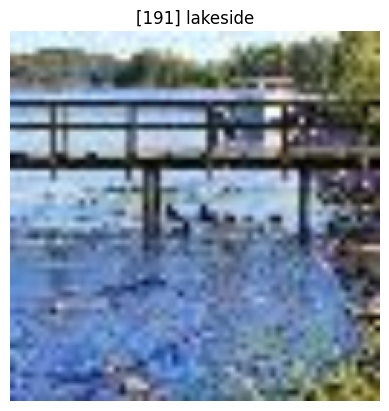

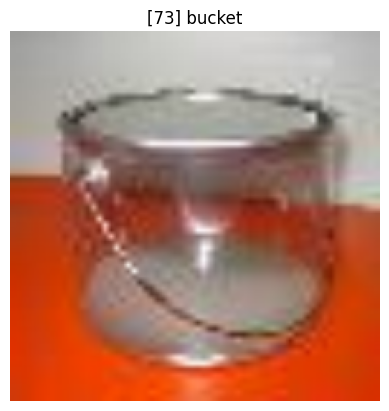

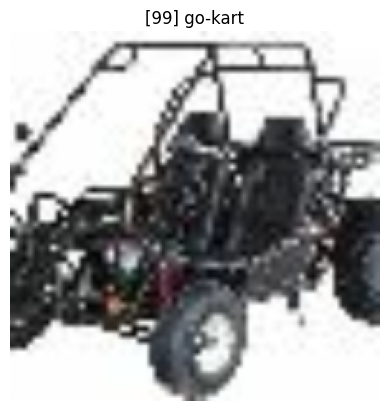

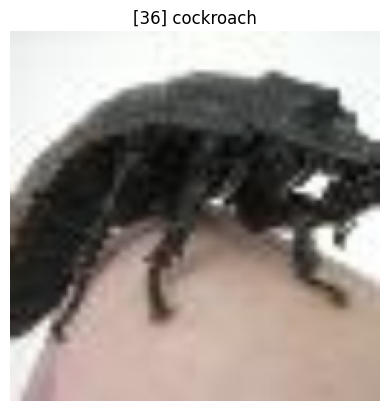

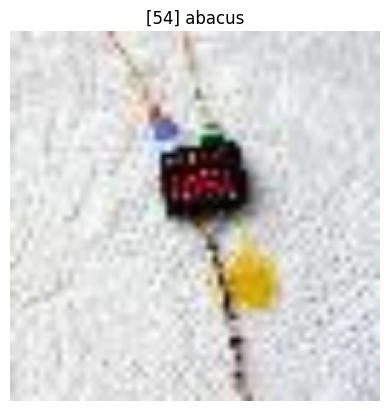

In [ ]:
for i in range(5):
  plt.imshow(test_images[i].permute(1,2,0))
  plt.title(f'[{test_labels[i].item()}] {tiny_label_to_text[test_labels[i].item()]}')
  plt.axis('off')
  plt.show()

In [ ]:
def reset_gpu():
  import gc
  gc.collect()
  if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [ ]:
def plot_clean_and_adv_img(clean_img, gt_label, adv_img, adv_pred):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))
  axes[0].imshow(clean_img.permute(1,2,0))
  axes[0].set_title(f'GT: [{gt_label}]  {tiny_label_to_text[gt_label]}')
  axes[0].axis("off")
  axes[1].imshow(adv_img.permute(1,2,0))
  axes[1].set_title(f'Predicted: [{adv_pred}] {tiny_label_to_text[adv_pred]}')
  axes[1].axis("off")
  plt.show()

In [ ]:
def get_successfully_classified(model, images, labels):
  model.move_to_device(device)
  preds = model.predict(images, all_captions)
  correct = preds.cpu()==labels
  return images[correct], labels[correct]

In [ ]:
# dump string in csv file
with open('results.csv', 'w') as f:
  f.write('attack_name,surr_model,target_model,tot_attacks,tot_success,asr\n')

def add_csv_row(attack_name, surr_model, target_model, tot_attacks, tot_success, file_path='results.csv'):
  if os.path.exists(file_path):
    with open(file_path, 'a') as f:
      f.write(f'{attack_name},{surr_model},{target_model},{tot_attacks},{tot_success},{tot_success/tot_attacks}\n')

In [ ]:
models = {}

clip_model, clip_preprocess = None, None
for model_name in ['RN50', 'ViT-B/16']:
  print(f'Model: {model_name}')
  clip_model, clip_preprocess = clip.load(model_name)
  models[model_name] = MyClipModel(clip_model, clip_preprocess, clip.tokenize, device=device)
del clip_model, clip_preprocess

pe_name = 'PE-Core-B16-224'
pe_model = pe.CLIP.from_config(pe_name, pretrained=True)
pe_tokenizer = transforms.get_text_tokenizer(pe_model.context_length)
pe_preprocessor = transforms.get_image_transform(pe_model.image_size)

models[pe_name] = MyPeModel(pe_model, pe_preprocessor, pe_tokenizer, device=device)

del pe_model, pe_tokenizer, pe_preprocessor

Model: RN50
Model: ViT-B/16
Missing keys for loading model: []
Unexpected keys for loading model: []


### UAPs

In [ ]:
reset_gpu()

epsilon=4./255
attack = UAP(epsilon=epsilon, iterations=500, device=device)

tot_images_for_eval = 500
tot_images_for_eval
print(f'Attack: {attack.get_name()}\n\n')
for surr_model_name, surr_model in models.items():
  print(f'SURROGATE {surr_model_name}\n ===============================')
  reset_seeds()

  reset_gpu()

  uaps = attack(surr_model, dataloader=dataloader, captions=all_captions, log_every_k=50)

  for targ_model_name, targ_model in models.items():
    targ_model.set_eval()
    targ_model.move_to_device(device)

    tot_attacks = 0
    tot_success = 0

    for batch_id, batch in enumerate(dataloader):
      if tot_attacks >= tot_images_for_eval:
        break

      images, labels = get_successfully_classified(targ_model, batch['image'], batch['label'])

      perturbed_imgs = torch.clamp(images.to(device) + uaps, 0, 1)
      targ_predictions = targ_model.predict(perturbed_imgs)

      tot_attacks += len(targ_predictions)
      tot_success += (targ_predictions != labels).float().sum().item()

    targ_model.move_to_device('cpu')

    asr = tot_success/tot_attacks
    print(f'{targ_model_name}: \t asr={asr}  ({int(tot_success)}/{tot_attacks})')
    add_csv_row(attack_name=attack.get_name(), surr_model=surr_model_name, target_model=targ_model_name, tot_attacks=tot_attacks, tot_success=tot_success)
  print('\n')

reset_gpu()

Attack: UAP-0.01568627450980392


SURROGATE RN50
0/6 	 ASR=0.562 	 (18/32) 	 (+ 0.562)
1/6 	 ASR=0.695 	 (1135/1632) 	 (+ 0.698)
2/6 	 ASR=0.730 	 (2360/3232) 	 (+ 0.766)
3/6 	 ASR=0.751 	 (3631/4832) 	 (+ 0.794)
4/6 	 ASR=0.793 	 (5102/6432) 	 (+ 0.919)
5/6 	 ASR=0.828 	 (6648/8032) 	 (+ 0.966)
6/6 	 ASR=0.853 	 (8212/9632) 	 (+ 0.978)
RN50: 	 asr=0.9532428355957768  (632/663)
ViT-B/16: 	 asr=0.2006048387096774  (199/992)
PE-Core-B16-224: 	 asr=0.14791987673343607  (192/1298)


SURROGATE ViT-B/16
0/6 	 ASR=0.438 	 (14/32) 	 (+ 0.438)
1/6 	 ASR=0.453 	 (740/1632) 	 (+ 0.454)
2/6 	 ASR=0.538 	 (1738/3232) 	 (+ 0.624)
3/6 	 ASR=0.621 	 (3001/4832) 	 (+ 0.789)
4/6 	 ASR=0.684 	 (4398/6432) 	 (+ 0.873)
5/6 	 ASR=0.731 	 (5872/8032) 	 (+ 0.921)
6/6 	 ASR=0.765 	 (7365/9632) 	 (+ 0.933)
RN50: 	 asr=0.4917043740573152  (326/663)
ViT-B/16: 	 asr=0.9213709677419355  (914/992)
PE-Core-B16-224: 	 asr=0.15562403697996918  (202/1298)


SURROGATE PE-Core-B16-224
0/6 	 ASR=0.250 	 (8/32) 	 (+ 0.250)


### Transfer

In [ ]:
reset_gpu()

tot_images_for_eval = 100

epsilon = 4./255
attacks = [
    FGSM(epsilon=epsilon, device=device),
    IFGSM(epsilon=epsilon, iterations=10, device=device),
    MIFGSM(epsilon=epsilon, iterations=10, decay_factor=0.9, device=device),
    TIFGSM(epsilon=epsilon, iterations=10, kernel_size=5, sigma=1, use_momentum=True, decay_factor=0.9, device=device),
    PGD(epsilon=epsilon, iterations=20, device=device),
    EmbeddingSpaceDisruption(epsilon=epsilon, iterations=250, target_last_layer=True, device=device)
    ]

for attack in attacks:
  print(f'ATTACK: {attack.get_name()}\n ===============================\n')
  for surr_model_name, surr_model in models.items():
    print(f'SURROGATE: {surr_model_name}\n -------------------------------')

    tot_attacks = torch.zeros(len(models))
    tot_success = torch.zeros(len(models))

    for batch_id, batch in enumerate(dataloader):
      images, labels = batch['image'].to(device), batch['label'].to(device)
      reset_seeds()

      reset_gpu()

      adv_imgs, adv_preds = attack(surr_model, images, labels, all_captions)

      for targ_model_id,(targ_model_name, targ_model) in enumerate(models.items()):
        if tot_attacks[targ_model_id] >= tot_images_for_eval:
          continue

        targ_model.set_eval()
        targ_model.move_to_device(device)

        # only test target model on images correctly classified when clean
        successfully_predicted = targ_model.predict(images, all_captions) == labels.cpu()
        images_for_target, labels_for_target = adv_imgs[successfully_predicted], labels[successfully_predicted]

        attack_success = targ_model.predict(images_for_target, all_captions) != labels_for_target.cpu()

        tot_attacks[targ_model_id] += len(attack_success)
        tot_success[targ_model_id] += attack_success.float().sum().item()


      if torch.all(tot_attacks>=tot_images_for_eval).item():
        break

    for targ_model_id, (targ_model_name,_) in enumerate(models.items()):
      asr = int(tot_success[targ_model_id])/tot_attacks[targ_model_id]
      print(f'{targ_model_name}:\t asr={asr:.5f}  ({int(tot_success[targ_model_id])}/{tot_attacks[targ_model_id]})')
      add_csv_row(attack_name=attack.get_name(), surr_model=surr_model_name, target_model=targ_model_name, tot_attacks=tot_attacks[targ_model_id], tot_success=tot_success[targ_model_id])
    print('\n')

  reset_gpu()
reset_gpu()

ATTACK: PGD-0.01568627450980392

SURROGATE: RN50
 -------------------------------
RN50:	 asr=0.99099  (110/111.0)
ViT-B/16:	 asr=0.10891  (11/101.0)
PE-Core-B16-224:	 asr=0.11111  (14/126.0)


SURROGATE: ViT-B/16
 -------------------------------
RN50:	 asr=0.50000  (53/106.0)
ViT-B/16:	 asr=1.00000  (106/106.0)
PE-Core-B16-224:	 asr=0.18919  (21/111.0)


SURROGATE: PE-Core-B16-224
 -------------------------------
RN50:	 asr=0.41509  (44/106.0)
ViT-B/16:	 asr=0.21698  (23/106.0)
PE-Core-B16-224:	 asr=1.00000  (111/111.0)


ATTACK: EmbeddingSpaceDisruption-0.01568627450980392

SURROGATE: RN50
 -------------------------------
RN50:	 asr=0.99057  (105/106.0)
ViT-B/16:	 asr=0.17925  (19/106.0)
PE-Core-B16-224:	 asr=0.13514  (15/111.0)


SURROGATE: ViT-B/16
 -------------------------------
RN50:	 asr=0.44118  (45/102.0)
ViT-B/16:	 asr=1.00000  (102/102.0)
PE-Core-B16-224:	 asr=0.15385  (16/104.0)


SURROGATE: PE-Core-B16-224
 -------------------------------
RN50:	 asr=0.41176  (42/102.0)
ViT

# Other TESTS

## Test models on clean images

In [ ]:
for model_name in list(models.keys()):
  del models[model_name]

In [ ]:
models = {}

# for model_name in tested_model_names:
clip_model, clip_preprocess = None, None
for model_name in ['RN50', 'ViT-B/16']:
  print(f'Model: {model_name}')
  clip_model, clip_preprocess = clip.load(model_name)
  models[model_name] = MyClipModel(clip_model, clip_preprocess, clip.tokenize, device=device)
  # models[model_name] = ModelWrapper(clip_model, clip_preprocess, clip.tokenize, device=device)
del clip_model, clip_preprocess

# PerceptionEncoder models available: ['PE-Core-G14-448', 'PE-Core-L14-336', 'PE-Core-B16-224']
pe_name = 'PE-Core-B16-224'
pe_model = pe.CLIP.from_config(pe_name, pretrained=True)
pe_tokenizer = transforms.get_text_tokenizer(pe_model.context_length)
pe_preprocessor = transforms.get_image_transform(pe_model.image_size)

models[pe_name] = MyPeModel(pe_model, pe_preprocessor, pe_tokenizer, device=device)
# models[pe_name] = ModelWrapper(pe_model, pe_preprocessor, pe_tokenizer, device=device)

del pe_model, pe_tokenizer, pe_preprocessor

Model: RN50


100%|███████████████████████████████████████| 244M/244M [00:11<00:00, 21.6MiB/s]


Model: ViT-B/16


100%|████████████████████████████████████████| 335M/335M [00:02<00:00, 172MiB/s]


PE-Core-B16-224.pt:   0%|          | 0.00/1.79G [00:00<?, ?B/s]

Missing keys for loading model: []
Unexpected keys for loading model: []


In [ ]:
sys.getsizeof(all_captions)

1656

In [ ]:
for model_name in models.keys():
  print(model_name)
  size_model = 0
  for param in models[model_name].parameters():
      if param.data.is_floating_point():
          size_model += param.numel() * torch.finfo(param.data.dtype).bits
      else:
          size_model += param.numel() * torch.iinfo(param.data.dtype).bits
  print(f"model size: {size_model} / bit | {size_model / 8e6:.2f} / MB")
  print()

RN50
model size: 2040395296 / bit | 255.05 / MB

ViT-B/16
model size: 2802794528 / bit | 350.35 / MB

PE-Core-B16-224
model size: 14325104672 / bit | 1790.64 / MB



In [ ]:
# Testing pretrained models on sample images
def test_model_on_img(model_name, image, gt_class, captions=all_captions,show_image=True):
  pred_class, probability=None, None
  try:
    if len(image.shape) < 4:
      image = image.unsqueeze(0)
    img = image

    model = models[model_name]

    with torch.no_grad():
      logits = model(img, captions)
    probabilities = torch.softmax(logits, -1).squeeze(0).cpu()
    probability = probabilities.max().item()
    pred_class = probabilities.argmax().item()

    if show_image:
      # plt.imshow(image.squeeze(0).permute(1, 2, 0))
      img = image[0].permute(1, 2, 0).cpu().numpy()
      plt.imshow(img)
      pred_label = tiny_label_to_text[pred_class].split(',')[0]
      gt_label = tiny_label_to_text[gt_class.item()].split(',')[0]
      plt.title(f"Predicted: ({pred_class}) {pred_label}, GT: ({gt_class.item()}) {gt_label}")
      plt.axis('off')
      plt.show()

    for idx in torch.topk(probabilities, k=3).indices.tolist():
      print(f'[{idx}] {tiny_label_to_text[idx]:<75} ({probabilities[idx].item()*100:.2f}%)')
  except:
    print('ERROR: there was a problem with the given image...')

  return pred_class, probability


RN50


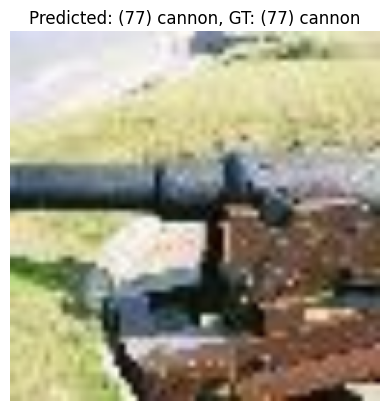

[77] cannon                                                                      (29.93%)
[127] projectile                                                                  (12.10%)
[74] bullet train                                                                (9.57%)
ViT-B/16


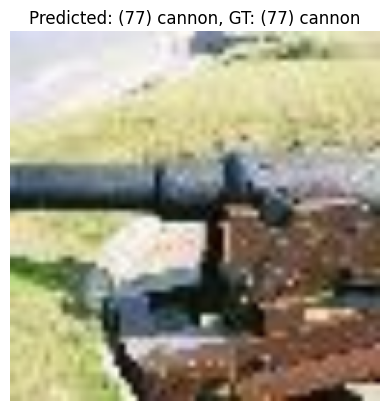

[77] cannon                                                                      (53.76%)
[127] projectile                                                                  (11.81%)
[61] barrel                                                                      (5.00%)
PE-Core-B16-224


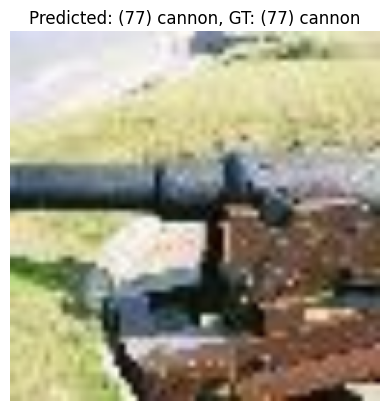

[77] cannon                                                                      (99.90%)
[127] projectile                                                                  (0.05%)
[61] barrel                                                                      (0.01%)


In [ ]:
# test on sample image

for batch in dataloader:
  imgs = batch['image']
  labels = batch['label']
  for model_name in models.keys():
    print(model_name)
    test_model_on_img(model_name, imgs[0].unsqueeze(0).clone(), labels[0].unsqueeze(0))
  break

## Models' performance on clean data

In [ ]:
tot_batches_for_eval = 50

tot_tests = 0
accuracies = defaultdict(int)
with torch.no_grad():
  for batch_id, batch in enumerate(dataloader):
    images,labels = batch['image'], batch['label']

    for model_name,model in models.items():
      model.set_eval()

      logits = model(images, all_captions)
      predictions = logits.cpu().argmax(1)

      accuracies[model_name] += (predictions==labels).sum().item()

    tot_tests += len(labels)
    if batch_id==(tot_batches_for_eval-1):
      break

for model_name, _ in models.items():
  accuracies[model_name] /= tot_tests
  print(f'{model_name}: {accuracies[model_name]}')

# accuracy with 50 batches:
#   RN50: 0.385
#   ViT-B/16: 0.5875
#   PE-Core-B16-224: 0.81375

RN50: 0.385
ViT-B/16: 0.5875
PE-Core-B16-224: 0.81375


## Attacking the models